# RNN Model

## Data Import


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras_tuner as kt
from keras.layers import SimpleRNN, Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import normalize
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)

In [2]:
df_train = pd.read_csv("dataset/output/no-oversampling/train.csv")
df_test = pd.read_csv("dataset/output/test.csv")

## Data Preparation


In [3]:
# split into X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["target"])
y_test = df_test["target"]

# normalize data
X_train = normalize(X_train)
X_test = normalize(X_test)
y_train = normalize(y_train.values.reshape(-1, 1))
y_test = normalize(y_test.values.reshape(-1, 1))

## Helper Functions


In [4]:
# This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric="accuracy"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

## Model Building


### Base Model


In [5]:
def create_model():
    model = Sequential()
    model.add(
        SimpleRNN(
            units=128,
            input_shape=(X_train.shape[1], 1),
            activation='relu'
        )
    )
    model.add(Dense(32, activation='relu'))  # Additional Dense layer
    model.add(Dense(1))  # Final output layer
    model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    return model

In [6]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20801 (81.25 KB)
Trainable params: 20801 (81.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test)
)

Epoch 1/100
281/281 [==============================] - 3s 3ms/step - loss: 0.6618 - accuracy: 0.6306 - val_loss: 0.6446 - val_accuracy: 0.6525
Epoch 2/100
281/281 [==============================] - 1s 3ms/step - loss: 0.6518 - accuracy: 0.6422 - val_loss: 0.6452 - val_accuracy: 0.6521
Epoch 3/100
281/281 [==============================] - 1s 2ms/step - loss: 0.6514 - accuracy: 0.6435 - val_loss: 0.6363 - val_accuracy: 0.6606
Epoch 4/100
281/281 [==============================] - 1s 2ms/step - loss: 0.6507 - accuracy: 0.6441 - val_loss: 0.6366 - val_accuracy: 0.6588
Epoch 5/100
281/281 [==============================] - 1s 2ms/step - loss: 0.6505 - accuracy: 0.6417 - val_loss: 0.6398 - val_accuracy: 0.6534
Epoch 6/100
281/281 [==============================] - 1s 2ms/step - loss: 0.6489 - accuracy: 0.6465 - val_loss: 0.6383 - val_accuracy: 0.6588
Epoch 7/100
281/281 [==============================] - 1s 2ms/step - loss: 0.6486 - accuracy: 0.6484 - val_loss: 0.6400 - val_accuracy: 0.6704

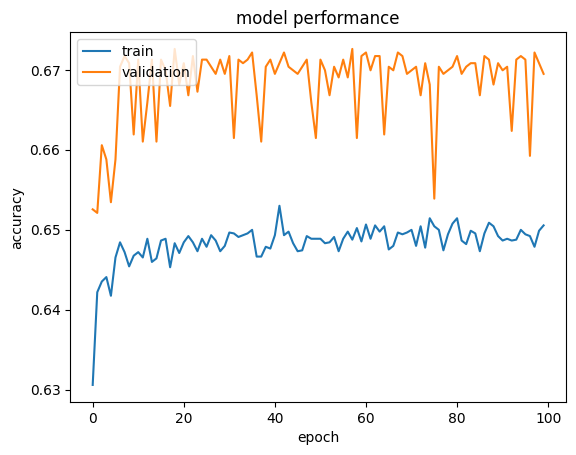

In [8]:
plot_hist(history)

In [9]:
# print confusion matrix and accuracy
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)  # Round predicted probabilities and convert to integers (0 or 1)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 0s 1ms/step
Accuracy:  0.6694915254237288

Confusion Matrix: 
 [[1324  122]
 [ 619  177]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.68      0.92      0.78      1446
         1.0       0.59      0.22      0.32       796

    accuracy                           0.67      2242
   macro avg       0.64      0.57      0.55      2242
weighted avg       0.65      0.67      0.62      2242



### Tuned Model


In [24]:
def tune_model(hp):
    units = hp.Int("units", min_value=32, max_value=256, step=32)
    dense_units = hp.Int("dense_units", min_value=16, max_value=64, step=16)
    activation = hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    loss = hp.Choice('loss', ['binary_crossentropy', 'binary_focal_crossentropy'])

    model = Sequential()
    model.add(
        SimpleRNN(
            units=units,
            input_shape=(X_train.shape[1], 1),
            activation=activation
        )
    )
    model.add(Dense(dense_units, activation=activation))  # Additional Dense layer
    model.add(Dense(1))  # Final output layer
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

tuner = kt.GridSearch(
    tune_model,
    objective='accuracy',
    directory="tuned_models",
    project_name="thyroid_rnn_tuning"
)

tuner.search(
    X_train,
    y_train,
    # epochs=30,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=5)]
)

Trial 576 Complete [00h 00m 03s]
accuracy: 0.6024532914161682

Best accuracy So Far: 0.6285196542739868
Total elapsed time: 00h 25m 08s
INFO:tensorflow:Oracle triggered exit


In [25]:
import pprint
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_model = tuner.hypermodel.build(best_hp)
print("best hyperparameters:\n", pprint.pformat(best_hp.values))
best_model.summary()

best hyperparameters:
 {'activation': 'relu',
 'dense_units': 64,
 'loss': 'binary_crossentropy',
 'optimizer': 'adam',
 'units': 256}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 256)               66048     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 82561 (322.50 KB)
Trainable params: 82561 (322.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history = best_model.fit(
    X_train,
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, y_test),
)

Epoch 1/100
281/281 [==============================] - 3s 6ms/step - loss: 0.6610 - accuracy: 0.6280 - val_loss: 0.6643 - val_accuracy: 0.6472
Epoch 2/100
281/281 [==============================] - 1s 5ms/step - loss: 0.6534 - accuracy: 0.6405 - val_loss: 0.6404 - val_accuracy: 0.6690
Epoch 3/100
281/281 [==============================] - 1s 5ms/step - loss: 0.6517 - accuracy: 0.6411 - val_loss: 0.6454 - val_accuracy: 0.6592
Epoch 4/100
281/281 [==============================] - 1s 5ms/step - loss: 0.6537 - accuracy: 0.6409 - val_loss: 0.6376 - val_accuracy: 0.6539
Epoch 5/100
281/281 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6460 - val_loss: 0.6440 - val_accuracy: 0.6708
Epoch 6/100
281/281 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.6437 - val_loss: 0.6490 - val_accuracy: 0.6459
Epoch 7/100
281/281 [==============================] - 1s 5ms/step - loss: 0.6512 - accuracy: 0.6460 - val_loss: 0.6395 - val_accuracy: 0.6699

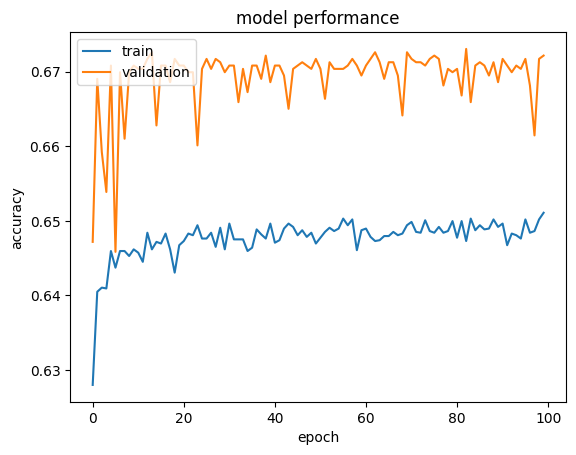

In [27]:
plot_hist(history)

In [28]:
# print confusion matrix and accuracy
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 0s 2ms/step
Accuracy:  0.6721677074041035

Confusion Matrix: 
 [[1361   85]
 [ 650  146]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.68      0.94      0.79      1446
         1.0       0.63      0.18      0.28       796

    accuracy                           0.67      2242
   macro avg       0.65      0.56      0.54      2242
weighted avg       0.66      0.67      0.61      2242

